In [15]:
# reference: https://www.kaggle.com/bulentsiyah/mnist-for-beginners-tensorflow-dnn-cnn-keras
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# for tensorboard
import os
from tensorflow.python.eager import context

from time import time

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

train_path = './data/train.csv'
test_path = './data/test.csv'

# reference - custom model example
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/learn/iris_custom_model.py

# https://gist.github.com/damienpontifex/1f03b966d36049b678efdddb54cef4eb

In [11]:
class get_data:
    def __init__(self, path, is_train=True):
        self.is_train = is_train
        
        # load csv file
        data = pd.read_csv(path)
        # split data to feature & label
        if is_train:
            self.feature = data.drop('label', axis=1)
            self.label = data['label']
        else:
            self.feature = data
        # free space
        del data
        
        self.feature = self.deal_feature()
        if is_train:
            self.label = self.deal_label()
            self.ts_f, self.ts_l, self.vs_f, self.vs_l = self.split_t_v()
            
    
    # EDA
    def describe_plot(self):
        sns.countplot(self.label)
    def describe_num(self):
        res = self.label.value_counts()
        print(res)
    
    # reference: How to Check If Any Value is NaN in a Pandas DataFrame
    # https://chartio.com/resources/tutorials/how-to-check-if-any-value-is-nan-in-a-pandas-dataframe/
    def check_missing_val(self, data_df):
        res = data_df.isnull().values.any()
        print(res)
        
    def deal_feature(self):
        # normolize data
#         feature = self.feature / 255.0
        feature = self.feature.values.reshape(-1, 28, 28, 1)
        return feature
    
    def show_digit(self):
        plt.imshow(self.feature[0][:,:,0])
        
    def deal_label(self):
        label = to_categorical(self.label, num_classes = 10)
        return label
    
    def split_t_v(self):
        # trainingSet_feature
        # trainingSet_label
        # validationSet_feature
        # validationSet_label
        
        ts_f, ts_l, vs_f, vs_l = \
        train_test_split(
            self.feature,
            self.label,
            test_size=0.1,
            random_state=2
        )
        return ts_f, ts_l, vs_f, vs_l

In [20]:
# class TrainValTensorBoard(TensorBoard):
#     def __init__(self, log_dir='./logs', **kwargs):
#         self.val_log_dir = os.path.join(log_dir, 'validation')
#         training_log_dir = os.path.join(log_dir, 'training')
#         super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

#     def set_model(self, model):
#         if context.executing_eagerly():
#             self.val_writer = tf.contrib.summary.create_file_writer(self.val_log_dir)
#         else:
#             self.val_writer = tf.summary.FileWriter(self.val_log_dir)
#         super(TrainValTensorBoard, self).set_model(model)

#     def _write_custom_summaries(self, step, logs=None):
#         logs = logs or {}
#         val_logs = {k.replace('val_', ''): v for k, v in logs.items() if 'val_' in k}
#         if context.executing_eagerly():
#             with self.val_writer.as_default(), tf.contrib.summary.always_record_summaries():
#                 for name, value in val_logs.items():
#                     tf.contrib.summary.scalar(name, value.item(), step=step)
#         else:
#             for name, value in val_logs.items():
#                 summary = tf.Summary()
#                 summary_value = summary.value.add()
#                 summary_value.simple_value = value.item()
#                 summary_value.tag = name
#                 self.val_writer.add_summary(summary, step)
#         self.val_writer.flush()

#         logs = {k: v for k, v in logs.items() if not 'val_' in k}
#         super(TrainValTensorBoard, self)._write_custom_summaries(step, logs)

#     def on_train_end(self, logs=None):
#         super(TrainValTensorBoard, self).on_train_end(logs)
#         self.val_writer.close()

class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        print(logs)
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

In [21]:
class create_model:
    def __init__(
        self,
        batch_size=42,
        num_classes=10,
        epochs=10,
        input_shape=(28, 28, 1),
        save_model=False,
        load_model=False,
        save_model_name='default',
        load_model_name='default',
        tensorboard=True
    ):
        self.batch_size=batch_size
        self.num_classes=num_classes
        self.epochs=epochs
        self.input_shape=input_shape
        
        self.save_model = save_model
        self.load_model = load_model
        self.save_model_json_path = './model/' + save_model_name + '.json'
        self.save_model_HDF5_path = './model/' + save_model_name + '.h5'
        self.load_model_json_path = './model/' + load_model_name + '.json'
        self.load_model_HDF5_path = './model/' + load_model_name + '.h5'
        self.has_tb = tensorboard
        if self.has_tb:
            log_dir = './tensorboard/{}'.format(time())
            self.tensorboard = TrainValTensorBoard(log_dir=log_dir, write_graph=False)
        
        self.model = Sequential()
        self.create_optimizer()
        self.buildDNN()
        self.model_compile()
        if load_model:
            self.load()
        
    def save(self):
        model_json = self.model.to_json()
        with open(self.save_model_json_path, 'w') as json_file:
            json_file.write(model_json)
        self.model.save_weights(self.save_model_HDF5_path)
        print("Saving the model...")
        
    def load(self):
        json_file = open(self.load_model_json_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        self.mode = model_from_json(loaded_model_json)
        # load weights into new model
        self.mode.load_weights(self.load_model_HDF5_path)
        print("Loaded model...")
        
    def buildDNN(self):
        self.model.add(Conv2D(32, kernel_size=(3, 3),padding='same',activation='relu',input_shape=self.input_shape))
        self.model.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
        self.model.add(MaxPool2D((2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Conv2D(64,kernel_size=(3, 3),padding='same', activation='relu'))
        self.model.add(Conv2D(64,kernel_size=(3, 3),activation='relu'))
        self.model.add(MaxPool2D((2, 2)))
        self.model.add(Dropout(0.25))

        self.model.add(Flatten())
        self.model.add(Dense(512, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(10, activation = "softmax"))

    def model_compile(self):
        self.model.compile(
            optimizer=self.adam,
            loss=keras.losses.categorical_crossentropy,
            metrics=['accuracy', self.recall]
        )
    
    def create_optimizer(self):
        self.sgd = keras.optimizers.SGD(lr=1e-4, momentum=0.9)
        self.rms_prop = keras.optimizers.RMSprop(lr=1e-4)
        self.adam = keras.optimizers.adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08) 
        self.adamax = keras.optimizers.Adamax(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
        self.adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
    
    def recall(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def train(self, ts_f, ts_l, vs_f, vs_l):
        self.create_learning_rate_reduction()
        self.get_datagenn(ts_f)
        
        cbs = [self.learning_rate_reduction]
        if self.has_tb:
            cbs.append(self.tensorboard)
        
        self.history = self.model.fit_generator(
            self.datagenn.flow(
                ts_f,
                vs_f,
                batch_size=self.batch_size
            ),
            epochs=self.epochs,
            validation_data=(ts_l,vs_l),
            verbose=2,
            steps_per_epoch=ts_f.shape[0] // self.batch_size,
            callbacks=cbs,
        )
        self.result = self.model.evaluate(x=ts_f, y=vs_f)
        print('Accuracy:', self.result[1])
        if self.save_model:
            self.save()
        self.print_plot()
    
    def create_learning_rate_reduction(self):
        self.learning_rate_reduction = ReduceLROnPlateau(
            monitor='val_acc', 
            patience=3, 
            verbose=1, 
            factor=0.5, 
            min_lr=0.0001
        )

    def get_datagenn(self, ts_f):
        self.datagenn = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image 
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False
        )  # randomly flip images

        self.datagenn.fit(ts_f)
    
    def print_plot(self):
        self.print_loss()
        self.print_acc()
    
    def print_loss(self):
        plt.plot(self.history.history['loss'])
        plt.title("Model Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Test'])
        plt.show()
        
    def print_acc(self):
        plt.plot(self.history.history['acc'])
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend(['Train','Test'])
        plt.show()
    
    def predict(self, test):
        pred_digits_test = np.argmax(self.model.predict(test), axis=1)
        image_id_test=[]
        for i in range(len(pred_digits_test)):
            image_id_test.append(i+1)
        d = {
            'ImageId': image_id_test,
            'Label': pred_digits_test
        }
        this.answer = pd.DataFrame(d)
        
    def save_pred(self, path):
        this.answer.to_csv(path, index=False)

Epoch 1/2
 - 159s - loss: 1.3940 - acc: 0.6937 - recall: 0.6283 - val_loss: 0.1168 - val_acc: 0.9710 - val_recall: 0.9657
{'val_loss': 0.11676230698552294, 'val_acc': 0.9709523770071211, 'val_recall': 0.96571428108783, 'loss': 1.3940337406242236, 'acc': 0.6937037029456367, 'recall': 0.6283068788292073, 'lr': 1e-04}
Epoch 2/2
 - 157s - loss: 0.2413 - acc: 0.9237 - recall: 0.9112 - val_loss: 0.0679 - val_acc: 0.9788 - val_recall: 0.9779
{'val_loss': 0.06787474344243188, 'val_acc': 0.9788095194668996, 'val_recall': 0.9778571384293693, 'loss': 0.24126084649940907, 'acc': 0.92370369661422, 'recall': 0.9112169239886854, 'lr': 1e-04}
37800/37800 [==============================] - 26s 695us/step
Accuracy: 0.9832804232804233
Saving the model...


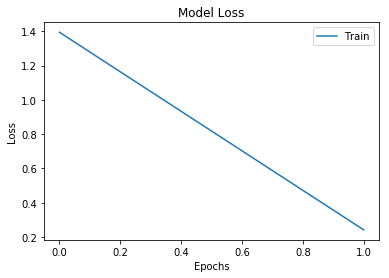

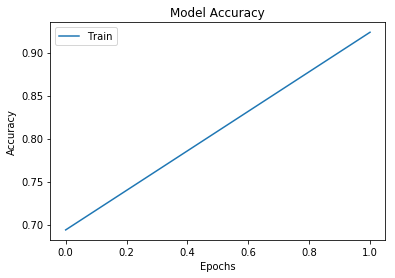

In [22]:
# model: keras_sequential
train = get_data(train_path)
model_seq = create_model(
    batch_size=10,
#     num_classes=10,
    epochs=2,
#     input_shape=(28, 28, 1),
    save_model=True,
#     load_model=True,
#     save_model_name='default',
#     load_model_name='default',
    tensorboard=True
)
model_seq.train(
    ts_f=train.ts_f,
    ts_l=train.ts_l,
    vs_f=train.vs_f,
    vs_l=train.vs_l
)